In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.multitest as multitest
import tqdm



In [9]:
outpath = "output/perform_test_tabular_data/"

In [10]:
def perform_t_tests(group1_vals, group2_vals, delta):
    mean1 = np.mean(group1_vals)
    mean2 = np.mean(group2_vals)
    
    # perform standard t-test (testing for difference)
    # consider switching to Welch's t-test (current assumes equal variances)
    diff_pval = stats.ttest_ind(a=group1_vals, b = group2_vals).pvalue

    # get t statistics for equivalence test
    # (X1 - X2 - delta)/sqrt(s1^2/n1 + s2^2/n2)
    t1 = (np.mean(group1_vals) - np.mean(group2_vals) - delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))

    # (X1 - X2 + delta)/sqrt(s1^2/n1 + s2^2/n2)
    t2 = (np.mean(group1_vals) - np.mean(group2_vals) + delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))

    # find degrees of freedom (n1 + n2 - 1)
    df = len(group1_vals) + len(group2_vals)

    # find p value for t1 (less than)
    p1 = stats.t.cdf(t1, df)

    # find p value for t2 (greater than)
    # sf is survival function: 1 - cdf
    p2 = stats.t.sf(t2, df)

    equiv_pval = np.max([p1, p2])
#     print("diff pvalue: {}\nequiv pvalue: {}".format(diff_pval, equiv_pval))
    return diff_pval, equiv_pval

def plot_groups(group1_vals, group2_vals):
    mean1 = np.mean(group1_vals)
    mean2 = np.mean(group2_vals)
    plt.hist(group1_vals,alpha=0.4, color=u'#1f77b4')
    plt.axvline(x=mean1, color=u'#1f77b4',linestyle="--")
    plt.hist(group2_vals,alpha = 0.4, color = u'#ff7f0e')
    plt.axvline(x=mean2, color=u'#ff7f0e',linestyle="--")
    # plt.axvline(x=np.mean(group2_vals), color="black")
    plt.title("difference in means: {:.3f}".format(mean1 - mean2))
    plt.show()

In [15]:
#dataname = "HLCA_normal_1000_CD4-positive-alpha-beta-T-cell_CD8-positive-alpha-beta-T-cell"
# dataname = "HLCA_normal_1000_classical-monocyte_non-classical-monocyte"
# dataname = "HLCA_normal_1000_alveolar-macrophage_elicited-macrophage"
# dataname = "HLCA_normal_1000_capillary-endothelial-cell_mast-cell"
#dataname = "HLCA_normal_1000_alveolar-macrophage_elicited-macrophage"
dataname = "HLCA_normal_1000_ciliated-columnar-cell-of-tracheobronchial-tree_CD8-positive-alpha-beta-T-cell"
csv_path = "/exports/home/jolivieri/equivalence_testing/scripts/output/sample_tabular_data/{}_1000_100.csv".format(dataname)
df = pd.read_csv(csv_path, index_col = 0)

In [16]:
deltas = [0.01, 0.03, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2]
alpha = 0.05

out_delt = {"delta" : [], "sig_both" : [], "sig_diff" : [], "sig_equiv" : [], "sig_neither" : []}

for delta in deltas:
    grouped_df = df.groupby("cell_type")

    out = {"gene" : [], "nnz_group1" : [], "nnz_group2" : [], "avg_group1" : [], 
           "avg_group2" : [], "eff_size" : [], "diff_pval" : [], "equiv_pval" : []}

    count = 0
    plot = False
    for gene in tqdm.tqdm([x for x in df.columns if x != "cell_type"]):

        samples = grouped_df[gene].apply(list)
        diff_pval, equiv_pval = perform_t_tests(samples[0], samples[1], delta)
        if plot and ((diff_pval < 0.05) or (equiv_pval > 0.05)):
#             print(gene)
            plt.hist(df[gene])
            plt.show()
            plot_groups(samples[0], samples[1])
        mean1 = np.mean(samples[0])
        mean2 = np.mean(samples[1])
        out["gene"].append(gene)
        out["nnz_group1"].append(np.count_nonzero(samples[0]))
        out["nnz_group2"].append(np.count_nonzero(samples[1]))
        out["avg_group1"].append(mean1)
        out["avg_group2"].append(mean2)
        out["eff_size"].append(np.abs(mean1 - mean2))
        out["diff_pval"].append(diff_pval)
        out["equiv_pval"].append(equiv_pval)

    out_df = pd.DataFrame.from_dict(out)

    out_df["diff_pval_adj"] = multitest.multipletests(out_df["diff_pval"], method="fdr_bh")[1]
    out_df["sig_diff"] = False
    out_df.loc[(out_df["diff_pval_adj"] < alpha) & (out_df["eff_size"] > delta), "sig_diff"] = True

    out_df["equiv_pval_adj"] = multitest.multipletests(out_df["equiv_pval"], method="fdr_bh")[1]
    out_df["sig_equiv"] = False
    out_df.loc[(out_df["equiv_pval_adj"] < alpha), "sig_equiv"] = True


    out_df["sig_both"] = out_df["sig_diff"] & out_df["sig_equiv"]
    tab = pd.crosstab(out_df['sig_equiv'], out_df['sig_diff'])
#     display(tab)
    out_delt["delta"].append(delta)
    try:
        out_delt["sig_both"].append(tab.loc[True,True])
    except:
        out_delt["sig_both"].append(0)
    try:
        out_delt["sig_diff"].append(tab.loc[False,True])
    except:
        out_delt["sig_diff"].append(0)
    try:
        out_delt["sig_equiv"].append(tab.loc[True,False])
    except:
        out_delt["sig_equiv"].append(0)
    try:
        out_delt["sig_neither"].append(tab.loc[False,False])
    except:
        out_delt["sig_neither"].append(0)

100%|██████████| 100/100 [00:00<00:00, 405.66it/s]


In [17]:
delt_df = pd.DataFrame.from_dict(out_delt)
delt_df

,delta,sig_both,sig_diff,sig_equiv,sig_neither
0,0.01,0,65,0,35
1,0.03,0,65,0,35
2,0.05,0,61,10,29
3,0.06,0,56,13,31
4,0.07,0,52,21,27
5,0.08,0,49,29,22
6,0.09,0,44,38,18
7,0.10,0,43,45,12
8,0.15,0,25,60,15
9,0.20,0,19,75,6


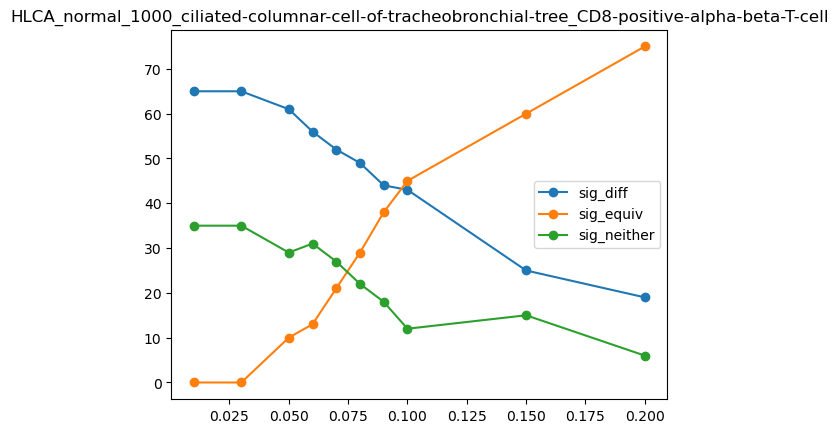

In [18]:
columns = ["sig_diff", "sig_equiv", "sig_neither"]
for c in columns:
    plt.plot(delt_df["delta"], delt_df[c],marker="o", label = c)
plt.legend()
plt.title(dataname)
plt.show()

In [83]:
tab

sig_diff,False,True
sig_equiv,,
False,2,6
True,92,0


In [50]:
out_df

,gene,nnz_group1,nnz_group2,avg_group1,avg_group2,eff_size,diff_pval,equiv_pval,diff_pval_adj,sig_diff,equiv_pval_adj,sig_equiv,sig_both
0,KDM2B,43,35,0.077934,0.087555,0.009620,0.629142,3.464277e-06,0.833760,False,2.165173e-05,True,False
1,SNX13,40,38,0.074981,0.102071,0.027090,0.191357,3.038178e-04,0.445017,False,9.206599e-04,True,False
2,MYOF,59,73,0.114975,0.186665,0.071690,0.005000,1.389385e-01,0.023809,False,1.903268e-01,False,False
3,PRNP,188,130,0.448404,0.414680,0.033725,0.463976,6.722409e-02,0.682318,False,1.014860e-01,False,False
4,TSR3,55,36,0.101651,0.084279,0.017371,0.418029,2.595958e-05,0.643121,False,1.236171e-04,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,DHX34,31,22,0.059688,0.049646,0.010042,0.547691,5.253142e-09,0.760682,False,1.050628e-07,True,False
96,CPQ,73,71,0.146434,0.191124,0.044690,0.112240,2.493156e-02,0.267238,False,4.155260e-02,True,False
97,NUDT14,56,40,0.112480,0.115242,0.002762,0.911454,3.845073e-05,0.930055,False,1.747760e-04,True,False
98,NSD1,75,54,0.144093,0.149950,0.005856,0.827835,2.079818e-04,0.930055,False,7.171786e-04,True,False


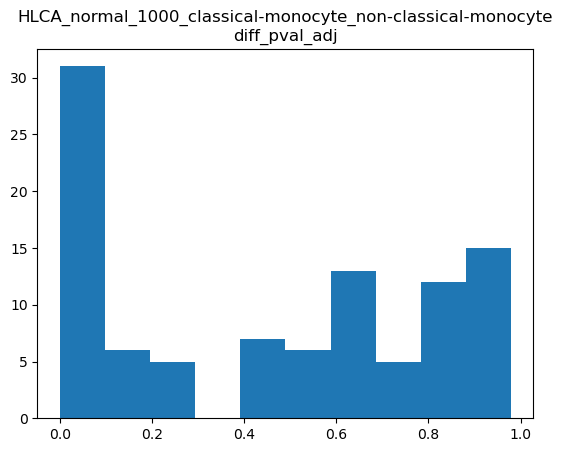

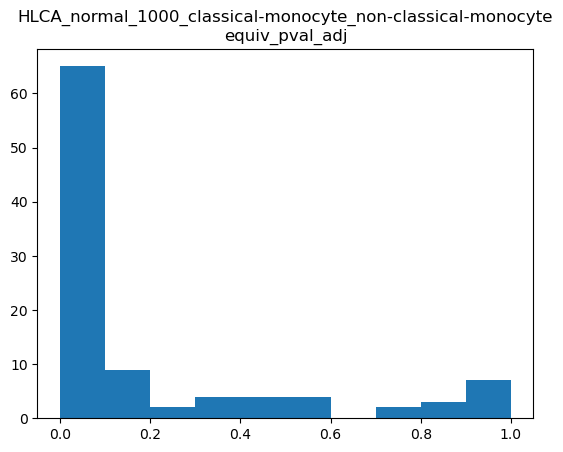

In [70]:
plt.hist(out_df["diff_pval_adj"])
plt.title("{}\ndiff_pval_adj".format(dataname))
plt.savefig("<path to save>")
plt.show()

plt.hist(out_df["equiv_pval_adj"])
plt.title("{}\nequiv_pval_adj".format(dataname))
plt.show()

In [71]:
out_df.sort_values("diff_pval_adj")
out_df.to_csv("{}{}_out.csv".format(outpath, dataname),index=False)

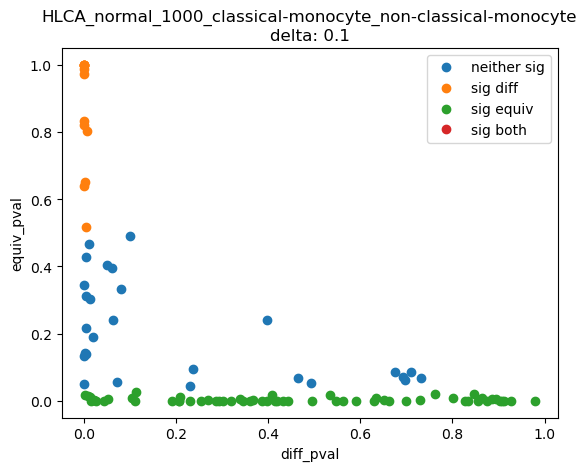

In [72]:

sub = out_df[(out_df["sig_diff"] == False) & (out_df["sig_equiv"] == False)]
plt.plot(sub["diff_pval"], sub["equiv_pval"],marker="o",linestyle="", label = "neither sig")

sub = out_df[(out_df["sig_diff"] == True) & (out_df["sig_equiv"] == False)]
plt.plot(sub["diff_pval"], sub["equiv_pval"],marker="o",linestyle="", label = "sig diff")

sub = out_df[(out_df["sig_diff"] == False) & (out_df["sig_equiv"] == True)]
plt.plot(sub["diff_pval"], sub["equiv_pval"],marker="o",linestyle="", label = "sig equiv")

sub = out_df[(out_df["sig_diff"] == True) & (out_df["sig_equiv"] == True)]
plt.plot(sub["diff_pval"], sub["equiv_pval"],marker="o",linestyle="", label = "sig both")

plt.xlabel("diff_pval")
plt.ylabel("equiv_pval")
plt.title("{}\ndelta: {}".format(dataname,delta))
plt.legend()
plt.show()

In [54]:
print(dataname)
print("delta: {}".format(delta))
pd.crosstab(out_df['sig_equiv'], out_df['sig_diff']) 

HLCA_normal_1000_classical-monocyte_non-classical-monocyte
delta: 0.1


sig_diff,False,True
sig_equiv,,
False,27,13
True,60,0
